In [1]:
import numpy as np
import json
import scipy.io as sio
import random
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from datetime import datetime
print(torch.__version__)
print(torch.cuda.is_available())

2.6.0+cu118
True


In [ ]:
# ---------------------------
# Dataset Loaders
# ---------------------------
def get_mnist_loaders(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# ---------------------------
# Top-K Auxiliary Loss
# ---------------------------
# def top_k_auxiliary_loss(x, x_hat, pre_codes, codes, dictionary, penalty=0.1):
#     residual = x - x_hat
#     mse = residual.square().mean()

#     pre_codes = torch.relu(pre_codes)
#     pre_codes = pre_codes - codes  # remove chosen codes

#     auxiliary_topk = torch.topk(pre_codes, k=pre_codes.shape[1] // 2, dim=1)
#     pre_codes = torch.zeros_like(codes).scatter(-1, auxiliary_topk.indices, auxiliary_topk.values)

#     residual_hat = pre_codes @ dictionary
#     auxiliary_mse = (residual - residual_hat).square().mean()

#     loss = mse + penalty * auxiliary_mse
#     return loss

def top_k_auxiliary_loss(x, x_hat, pre_codes, codes, dictionary, penalty=0.1):
    residual = x - x_hat
    mse = residual.square().mean()

    # Keep pre_codes shape: (B, C, H, W)
    B, C, H, W = pre_codes.shape
    pre_codes_relu = F.relu(pre_codes) - codes  # remove selected codes
    pre_codes_flat = pre_codes_relu.view(B, C, -1)

    # Top 50% codes per channel across spatial dimension
    k_aux = pre_codes_flat.shape[2] // 2
    topk_vals, topk_indices = torch.topk(pre_codes_flat, k=k_aux, dim=2)

    aux_codes = torch.zeros_like(pre_codes_flat).scatter(2, topk_indices, topk_vals)
    aux_codes_reshaped = aux_codes.view(B, C, H, W)

    # Apply ConvTranspose2d manually using functional conv_transpose2d
    residual_hat = F.conv_transpose2d(aux_codes_reshaped, dictionary, padding=dictionary.shape[2] // 2)

    auxiliary_mse = (residual - residual_hat).square().mean()

    return mse + penalty * auxiliary_mse


def analyze_dictionary_usage(model, dataloader, device):
    model.eval()
    num_channels = model.encoder.out_channels
    l0_counts = torch.zeros(num_channels).to(device)
    l1_sums = torch.zeros(num_channels).to(device)

    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            _, pre_codes, codes, _ = model(x)

            # Flatten codes: (B, C, H, W) → (C, B*H*W)
            codes_flat = codes.view(codes.shape[0], codes.shape[1], -1)

            # ℓ₀: Count non-zero activations per channel
            l0_counts += (codes_flat != 0).sum(dim=(0, 2))

            # ℓ₁: Sum of absolute activations
            l1_sums += codes_flat.abs().sum(dim=(0, 2))

    return l0_counts.cpu(), l1_sums.cpu()

def get_top_atoms(l0_counts, l1_sums, top_k=10):
    top_l0 = torch.topk(l0_counts, top_k).indices
    top_l1 = torch.topk(l1_sums, top_k).indices
    return top_l0, top_l1


def visualize_dictionary(dictionary, num_kernels=1000, cols=25):
    dictionary = dictionary.detach().cpu()
    kernels = dictionary.squeeze(0)  # shape: (num_kernels, H, W)

    rows = num_kernels // cols + int(num_kernels % cols != 0)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.2, rows * 1.2))
    axes = axes.flatten()

    for i in range(num_kernels):
        ax = axes[i]
        kernel = kernels[i].squeeze().numpy()
        ax.imshow(kernel, cmap='gray')
        ax.axis('off')
        ax.set_title(f'{i}', fontsize=6)

    # Hide any unused axes
    for j in range(num_kernels, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


# def visualize_dictionary(dictionary, num_kernels=1000):
#     dictionary = dictionary.detach().cpu()
#     kernels = dictionary.squeeze(0)  # shape (in_channels, H, W)

#     fig, axes = plt.subplots(1, num_kernels, figsize=(num_kernels * 2, 2))
#     for i in range(num_kernels):
#         ax = axes[i]
#         kernel = kernels[i].squeeze().numpy()  # <-- squeeze here
#         ax.imshow(kernel, cmap='gray')
#         ax.axis('off')
#         ax.set_title(f'Kernel {i+1}')
#     plt.show()

def visualize_selected_kernels(dictionary, selected_indices, title):
    dictionary = dictionary.detach().cpu()
    kernels = dictionary.squeeze(0)  # (C, H, W)

    fig, axes = plt.subplots(1, len(selected_indices), figsize=(2 * len(selected_indices), 2))
    fig.suptitle(title, fontsize=14)
    for i, idx in enumerate(selected_indices):
        ax = axes[i]
        kernel = kernels[idx].squeeze().numpy()
        ax.imshow(kernel, cmap='gray')
        ax.axis('off')
        ax.set_title(f'{idx.item()}')
    plt.show()

def plot_l0_l1_composite(dictionary, top_l0, top_l1, title='Feature Selection vs Activation Levels'):
    """
    Visualizes dictionary atoms selected by top-ℓ₀ and top-ℓ₁ stats in two rows.

    Args:
        dictionary: Tensor of shape (1, C, H, W) from ConvTranspose2d
        top_l0: Tensor of top-k indices based on ℓ₀ (activation frequency)
        top_l1: Tensor of top-k indices based on ℓ₁ (activation magnitude)
    """
    dictionary = dictionary.detach().cpu().squeeze(0)  # (C, H, W)
    num_kernels = len(top_l0)
    fig, axes = plt.subplots(2, num_kernels, figsize=(num_kernels * 1.5, 3))
    fig.suptitle(title, fontsize=16)

    for i in range(num_kernels):
        # Top row: ℓ₀
        ax_top = axes[0, i]
        kernel_l0 = dictionary[top_l0[i]].squeeze().numpy()
        ax_top.imshow(kernel_l0, cmap='gray')
        ax_top.axis('off')
        if i == 0:
            ax_top.set_ylabel(r'Top $\ell_0$', fontsize=12)

        # Bottom row: ℓ₁
        ax_bot = axes[1, i]
        kernel_l1 = dictionary[top_l1[i]].squeeze().numpy()
        ax_bot.imshow(kernel_l1, cmap='gray')
        ax_bot.axis('off')
        if i == 0:
            ax_bot.set_ylabel(r'Top $\ell_1$', fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
# ---------------------------
# Sparse Autoencoder
# ---------------------------
class SparseAutoencoder(nn.Module):
    def __init__(self, in_channels=1, num_kernels=16, kernel_size=7, k=10):
        super().__init__()
        self.k = k
        self.encoder = nn.Conv2d(in_channels, num_kernels, kernel_size=kernel_size, padding=kernel_size // 2)
        self.decoder = nn.ConvTranspose2d(num_kernels, in_channels, kernel_size=kernel_size, padding=kernel_size // 2)

    def forward(self, x):
        pre_codes = self.encoder(x)
        B, C, H, W = pre_codes.shape
        pre_codes_flat = pre_codes.view(B, C, -1)

        epsilon = 1e-6
        topk_vals, _ = torch.topk(torch.abs(pre_codes_flat), self.k, dim=2)
        threshold = topk_vals[:, :, -1].unsqueeze(-1)
        codes_flat = torch.where(torch.abs(pre_codes_flat) >= (threshold - epsilon), pre_codes_flat, torch.zeros_like(pre_codes_flat))

        codes = codes_flat.view_as(pre_codes)
        x_recon = self.decoder(codes)

        dictionary = self.decoder.weight

        return x_recon, pre_codes, codes, dictionary
# ---------------------------
# Training Loop
# ---------------------------
def train(model, dataloader, optimizer, criterion, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for data, _ in dataloader:
            data = data.to(device)
            optimizer.zero_grad()
            x_hat, pre_codes, codes, dictionary = model(data)
            loss = criterion(data, x_hat, pre_codes, codes, dictionary)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(dataloader):.6f}")

# ---------------------------
# Main Function
# ---------------------------
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SparseAutoencoder(in_channels=1, num_kernels=1000, kernel_size=28, k=10).to(device)

    train_loader, test_loader = get_mnist_loaders(batch_size=128)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

    train(model, train_loader, optimizer, top_k_auxiliary_loss, device, num_epochs=1)
    # Analyze usage across training set
    l0_counts, l1_sums = analyze_dictionary_usage(model, train_loader, device)
    top_l0, top_l1 = get_top_atoms(l0_counts, l1_sums, top_k=10)
    plot_l0_l1_composite(model.decoder.weight, top_l0, top_l1, title="MP-SAE Dictionary Usage")


    visualize_selected_kernels(model.decoder.weight, top_l0, title="Top Atoms by L0")
    visualize_selected_kernels(model.decoder.weight, top_l1, title="Top Atoms by L1")

    visualize_dictionary(model.decoder.weight, num_kernels=1000)

    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    save_dir = os.path.join("saved_models", timestamp)
    os.makedirs(save_dir, exist_ok=True)

    model_path = os.path.join(save_dir, "trained_model.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")
    

# ---------------------------
# Run It
# ---------------------------
if __name__ == '__main__':
    main()                                                                                                                                                                                                                                               

OutOfMemoryError: CUDA out of memory. Tried to allocate 412.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 2.72 GiB is allocated by PyTorch, and 507.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [7]:
import matplotlib.pyplot as plt

def plot_l0_l1_composite(dictionary, top_l0, top_l1, title='Feature Selection vs Activation Levels'):
    """
    Visualizes dictionary atoms selected by top-ℓ₀ and top-ℓ₁ stats in two rows.

    Args:
        dictionary: Tensor of shape (1, C, H, W) from ConvTranspose2d
        top_l0: Tensor of top-k indices based on ℓ₀ (activation frequency)
        top_l1: Tensor of top-k indices based on ℓ₁ (activation magnitude)
    """
    dictionary = dictionary.detach().cpu().squeeze(0)  # (C, H, W)
    num_kernels = len(top_l0)
    fig, axes = plt.subplots(2, num_kernels, figsize=(num_kernels * 1.5, 3))
    fig.suptitle(title, fontsize=16)

    for i in range(num_kernels):
        # Top row: ℓ₀
        ax_top = axes[0, i]
        kernel_l0 = dictionary[top_l0[i]].squeeze().numpy()
        ax_top.imshow(kernel_l0, cmap='gray')
        ax_top.axis('off')
        if i == 0:
            ax_top.set_ylabel(r'Top $\ell_0$', fontsize=12)

        # Bottom row: ℓ₁
        ax_bot = axes[1, i]
        kernel_l1 = dictionary[top_l1[i]].squeeze().numpy()
        ax_bot.imshow(kernel_l1, cmap='gray')
        ax_bot.axis('off')
        if i == 0:
            ax_bot.set_ylabel(r'Top $\ell_1$', fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


In [ ]:
plot_l0_l1_composite(model.decoder.weight, top_l0, top_l1, title="MP-SAE Dictionary Usage")


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import umap.umap_ as umap
# ----------------------
# Visualize Atoms (Conv Filters)
# ----------------------
def visualize_atoms(filters, title="Learned Atoms"):
    filters = filters.detach().cpu().numpy()
    n = filters.shape[0]
    fig, axes = plt.subplots(1, n, figsize=(n, 2))
    for i, ax in enumerate(axes):
        ax.imshow(filters[i, 0], cmap='gray')
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

def visualize_conv_atoms(conv_weights, num_atoms=16, title="Conv Atoms"):
    weights = conv_weights[:num_atoms].cpu().detach()
    weights = weights.squeeze(1)  # assume grayscale: [C_out, 1, H, W]
    n_cols = min(num_atoms, 10)
    n_rows = int(np.ceil(num_atoms / n_cols))
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows))
    axs = axs.flatten()
    for i in range(num_atoms):
        axs[i].imshow(weights[i], cmap='gray')
        axs[i].axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# ----------------------
# Sort and Visualize Atoms by L0 and L1 Norms
# ----------------------
# code --> B,C,H,W 

# sorted indices
def sort_atoms_by_l0(z_sparse):
    l0_scores = (z_sparse != 0).float().sum(dim=[0, 2, 3])
    return l0_scores

def sort_atoms_by_l1(z_sparse):
    l1_scores = torch.abs(z_sparse).sum(dim=[0, 2, 3])
    return l1_scores

# visualize
def visualize_sorted_atoms(filters, scores, title):
    sorted_idx = torch.argsort(scores, descending=True)
    filters = filters[sorted_idx]
    visualize_atoms(filters, title)

# ----------------------
# Visualize Code Activations (Dense vs Conv)
# ----------------------
def visualize_codes_conv(z_sparse):
    avg_act = z_sparse.mean(dim=[0, 2, 3])
    freq = (z_sparse != 0).float().sum(dim=[0, 2, 3])
    plt.figure(figsize=(6, 4))
    plt.scatter(freq.cpu(), avg_act.cpu())
    plt.xlabel("Activation Frequency")
    plt.ylabel("Average Activation")
    plt.title("Figure 4: Avg Activation vs Frequency")
    plt.grid(True)
    plt.show()

# ----------------------
# Coherence (Babel Score)
# ----------------------
def babel_score(dictionary):
    D = dictionary.view(dictionary.size(0), -1)  # (n_kernels, flattened)
    D = F.normalize(D, dim=1)
    G = torch.matmul(D, D.T)  # Gram matrix
    mask = torch.eye(G.shape[0], device=G.device).bool()
    G.masked_fill_(mask, -1.0)
    return G.max(dim=1).values.mean().item()

# ----------------------
# Babel Score for selected atoms
# ----------------------
def babel_score_for_sample(z_sparse, dictionary):
    B, C, H, W = z_sparse.shape
    scores = []
    for i in range(B):
        active = (z_sparse[i] != 0).view(C, -1).sum(dim=1) > 0
        active_dict = dictionary[active]
        if active_dict.shape[0] > 1:
            scores.append(babel_score(active_dict))
    return np.mean(scores)

# ----------------------
# Sequential Reconstruction
# ----------------------
def sequential_reconstruction(image, z_sparse, decoder, top_k):
    C = z_sparse.shape[1]
    flat = z_sparse.view(C, -1)
    l1_scores = torch.norm(flat, p=1, dim=1)
    topk_indices = torch.topk(l1_scores, top_k).indices

    reconstructions = []
    used_indices = []
    for k in range(1, top_k + 1):
        mask = torch.zeros_like(z_sparse)
        for idx in topk_indices[:k]:
            mask[:, idx] = z_sparse[:, idx]
        recon = decoder(mask)
        reconstructions.append(recon[0, 0].detach().cpu().numpy())
        used_indices.append(topk_indices[:k].cpu().numpy())

    fig, axes = plt.subplots(2, top_k, figsize=(2 * top_k, 4))
    for i in range(top_k):
        axes[0, i].set_title(f"Atom {i+1}")
        axes[0, i].imshow(used_indices[i].reshape(1, -1), cmap='viridis', aspect='auto')
        axes[1, i].imshow(reconstructions[i], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    plt.suptitle("Figure 6: Sequential Reconstruction")
    plt.show()

# ----------------------
# Clustering
# ----------------------
def cluster_images(images, n_clusters=10):
    flat = images.view(images.shape[0], -1).cpu().numpy()
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(flat)
    return labels

def cluster_atoms(dictionary, method='umap'):
    D = dictionary.view(dictionary.size(0), -1).cpu().numpy()
    if method == 'umap':
        reducer = umap.UMAP()
    else:
        reducer = TSNE()
    embed = reducer.fit_transform(D)
    plt.figure(figsize=(6, 6))
    plt.scatter(embed[:, 0], embed[:, 1], cmap='Spectral')
    plt.title("Clustering of Atoms")
    plt.show()

def cluster_codes(z_sparse, method='umap'):
    B, C, H, W = z_sparse.shape
    flat_codes = z_sparse.view(B, -1).cpu().numpy()
    if method == 'umap':
        reducer = umap.UMAP()
    else:
        reducer = TSNE()
    embed = reducer.fit_transform(flat_codes)
    plt.figure(figsize=(6, 6))
    plt.scatter(embed[:, 0], embed[:, 1], cmap='Spectral')
    plt.title("Clustering of Code Distributions")
    plt.show()

In [5]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
# import os
# from datetime import datetime
# import matplotlib.pyplot as plt


# # ---------------------------
# # Dataset Loaders
# # ---------------------------
# def get_mnist_loaders(batch_size=128):
#     transform = transforms.Compose([
#         transforms.ToTensor()
#     ])
#     train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
#     test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
#     return train_loader, test_loader


# # ---------------------------
# # Top-K Auxiliary Loss
# # ---------------------------
# def top_k_auxiliary_loss(x, x_hat, pre_codes, codes, dictionary, penalty=0.1):
#     residual = x - x_hat
#     mse = residual.square().mean()

#     # Keep pre_codes shape: (B, C, H, W)
#     B, C, H, W = pre_codes.shape
#     pre_codes_relu = F.relu(pre_codes) - codes  # remove selected codes
#     pre_codes_flat = pre_codes_relu.view(B, C, -1)

#     # Top 50% codes per channel across spatial dimension
#     k_aux = pre_codes_flat.shape[2] // 2
#     topk_vals, topk_indices = torch.topk(pre_codes_flat, k=k_aux, dim=2)

#     aux_codes = torch.zeros_like(pre_codes_flat).scatter(2, topk_indices, topk_vals)
#     aux_codes_reshaped = aux_codes.view(B, C, H, W)

#     # Apply ConvTranspose2d manually using functional conv_transpose2d
#     residual_hat = F.conv_transpose2d(aux_codes_reshaped, dictionary, padding=dictionary.shape[2] // 2)

#     auxiliary_mse = (residual - residual_hat).square().mean()

#     return mse + penalty * auxiliary_mse


# def analyze_dictionary_usage(model, dataloader, device):
#     model.eval()
#     num_channels = model.encoder.out_channels
#     l0_counts = torch.zeros(num_channels).to(device)
#     l1_sums = torch.zeros(num_channels).to(device)

#     with torch.no_grad():
#         for x, _ in dataloader:
#             x = x.to(device)
#             _, pre_codes, codes, _ = model(x)

#             # Flatten codes: (B, C, H, W) → (C, B*H*W)
#             codes_flat = codes.view(codes.shape[0], codes.shape[1], -1)

#             # ℓ₀: Count non-zero activations per channel
#             l0_counts += (codes_flat != 0).sum(dim=(0, 2))

#             # ℓ₁: Sum of absolute activations
#             l1_sums += codes_flat.abs().sum(dim=(0, 2))

#     return l0_counts.cpu(), l1_sums.cpu()


# def get_top_atoms(l0_counts, l1_sums, top_k=16):
#     top_l0 = torch.topk(l0_counts, top_k).indices
#     top_l1 = torch.topk(l1_sums, top_k).indices
#     return top_l0, top_l1


# # --- Normalization helper for kernels ---
# def normalize_kernel(kernel):
#     min_val = kernel.min()
#     max_val = kernel.max()
#     if max_val > min_val:
#         kernel_norm = (kernel - min_val) / (max_val - min_val)
#     else:
#         kernel_norm = kernel - min_val  # all zeros if constant
#     return kernel_norm


# def visualize_dictionary(dictionary, num_kernels=16):
#     dictionary = dictionary.detach().cpu()
#     kernels = dictionary.squeeze(0)  # shape (C, H, W)

#     fig, axes = plt.subplots(1, num_kernels, figsize=(num_kernels * 2, 2))
#     for i in range(num_kernels):
#         ax = axes[i]
#         kernel = kernels[i].squeeze()
#         kernel_norm = normalize_kernel(kernel)
#         ax.imshow(kernel_norm.numpy(), cmap='gray')
#         ax.axis('off')
#         ax.set_title(f'Kernel {i+1}')
#     plt.show()


# def visualize_selected_kernels(dictionary, selected_indices, title):
#     dictionary = dictionary.detach().cpu()
#     kernels = dictionary.squeeze(0)  # (C, H, W)

#     fig, axes = plt.subplots(1, len(selected_indices), figsize=(2 * len(selected_indices), 2))
#     fig.suptitle(title, fontsize=14)
#     for i, idx in enumerate(se9ected_indices):
#         ax = axes[i]
#         kernel = kernels[idx].squeeze()
#         kernel_norm = normalize_kernel(kernel)
#         ax.imshow(kernel_norm.numpy(), cmap='gray')
#         ax.axis('off')
#         ax.set_title(f'{idx.item()}')
#     plt.show()


# def plot_l0_l1_composite(dictionary, top_l0, top_l1, title='Feature Selection vs Activation Levels'):
#     dictionary = dictionary.detach().cpu().squeeze(0)  # (C, H, W)
#     num_kernels = len(top_l0)
#     fig, axes = plt.subplots(2, num_kernels, figsize=(num_kernels * 1.5, 3))
#     fig.suptitle(title, fontsize=16)

#     for i in range(num_kernels):
#         # Top row: ℓ₀
#         ax_top = axes[0, i]
#         kernel_l0 = dictionary[top_l0[i]].squeeze()
#         kernel_l0_norm = normalize_kernel(kernel_l0)
#         ax_top.imshow(kernel_l0_norm.numpy(), cmap='gray')
#         ax_top.axis('off')
#         if i == 0:
#             ax_top.set_ylabel(r'Top $\ell_0$', fontsize=12)

#         # Bottom row: ℓ₁
#         ax_bot = axes[1, i]
#         kernel_l1 = dictionary[top_l1[i]].squeeze()
#         kernel_l1_norm = normalize_kernel(kernel_l1)
#         ax_bot.imshow(kernel_l1_norm.numpy(), cmap='gray')
#         ax_bot.axis('off')
#         if i == 0:
#             ax_bot.set_ylabel(r'Top $\ell_1$', fontsize=12)

#     plt.tight_layout()
#     plt.subplots_adjust(top=0.85)
#     plt.show()


# # ---------------------------
# # Sparse Autoencoder
# # ---------------------------
# class SparseAutoencoder(nn.Module):
#     def __init__(self, in_channels=1, num_kernels=16, kernel_size=7, k=10):
#         super().__init__()
#         self.k = k
#         self.encoder = nn.Conv2d(in_channels, num_kernels, kernel_size=kernel_size, padding=kernel_size // 2)
#         self.decoder = nn.ConvTranspose2d(num_kernels, in_channels, kernel_size=kernel_size, padding=kernel_size // 2)

#     def forward(self, x):
#         pre_codes = self.encoder(x)
#         B, C, H, W = pre_codes.shape
#         pre_codes_flat = pre_codes.view(B, C, -1)

#         epsilon = 1e-6
#         topk_vals, _ = torch.topk(torch.abs(pre_codes_flat), self.k, dim=2)
#         threshold = topk_vals[:, :, -1].unsqueeze(-1)
#         codes_flat = torch.where(torch.abs(pre_codes_flat) >= (threshold - epsilon), pre_codes_flat, torch.zeros_like(pre_codes_flat))

#         codes = codes_flat.view_as(pre_codes)
#         x_recon = self.decoder(codes)

#         dictionary = self.decoder.weight

#         return x_recon, pre_codes, codes, dictionary


# # ---------------------------
# # Training Loop
# # ---------------------------
# def train(model, dataloader, optimizer, criterion, device, num_epochs=10):
#     model.train()
#     for epoch in range(num_epochs):
#         epoch_loss = 0.0
#         for data, _ in dataloader:
#             data = data.to(device)
#             optimizer.zero_grad()
#             x_hat, pre_codes, codes, dictionary = model(data)
#             loss = criterion(data, x_hat, pre_codes, codes, dictionary)
#             loss.backward()
#             optimizer.step()
#             epoch_loss += loss.item()
#         print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(dataloader):.6f}")


# # ---------------------------
# # Main Function
# # ---------------------------
# def main():
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = SparseAutoencoder(in_channels=1, num_kernels=16, kernel_size=7, k=10).to(device)

#     train_loader, test_loader = get_mnist_loaders(batch_size=128)
#     optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

#     train(model, train_loader, optimizer, top_k_auxiliary_loss, device, num_epochs=5)
    
#     # Analyze usage across training set
#     l0_counts, l1_sums = analyze_dictionary_usage(model, train_loader, device)
#     top_l0, top_l1 = get_top_atoms(l0_counts, l1_sums, top_k=8)
#     plot_l0_l1_composite(model.decoder.weight, top_l0, top_l1, title="MP-SAE Dictionary Usage")

#     visualize_selected_kernels(model.decoder.weight, top_l0, title="Top Atoms by L0")
#     visualize_selected_kernels(model.decoder.weight, top_l1, title="Top Atoms by L1")

#     # visualize_dictionary(model.decoder.weight, num_kernels=16)

#     timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
#     save_dir = os.path.join("saved_models", timestamp)
#     os.makedirs(save_dir, exist_ok=True)

#     model_path = os.path.join(save_dir, "trained_model.pth")
#     torch.save(model.state_dict(), model_path)
#     print(f"Model saved to {model_path}")


# # ---------------------------
# # Run It
# # ---------------------------
# if __name__ == '__main__':
#     main()


torch.Size([128, 16, 28, 28])


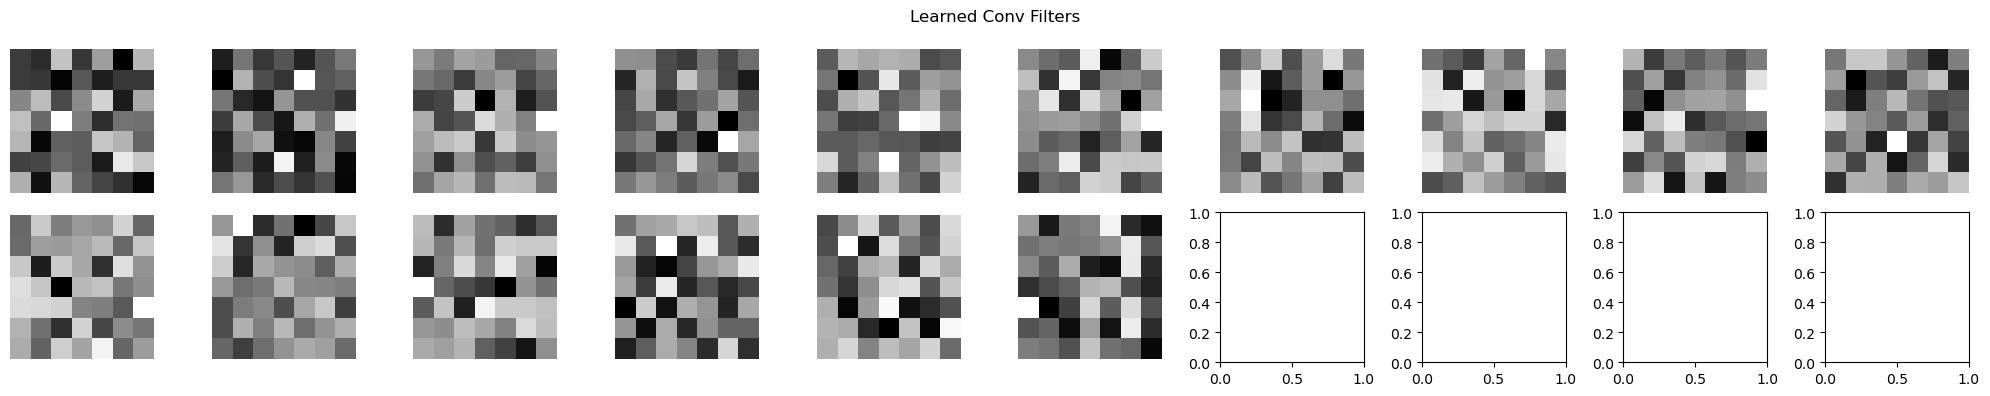

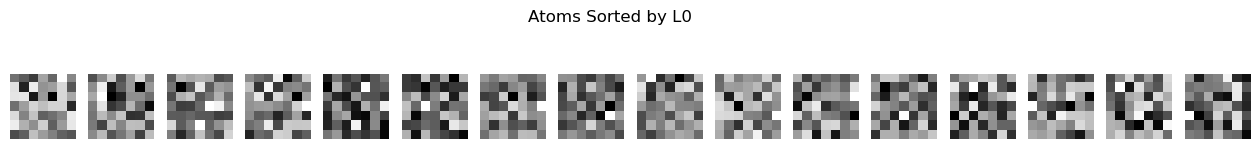

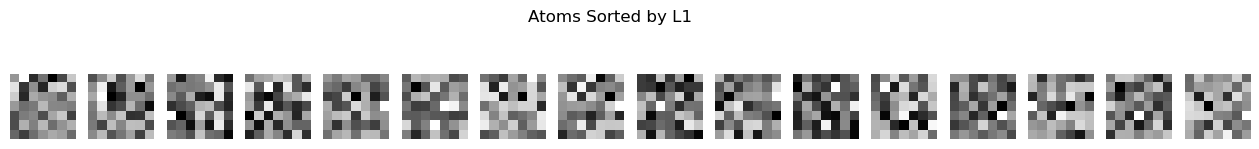

torch.Size([16]) torch.Size([16])


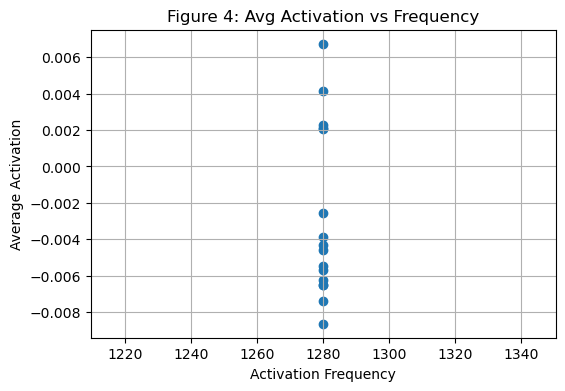

Global Babel Score: 0.2362
Per-Sample Babel Score (mean): 0.2362


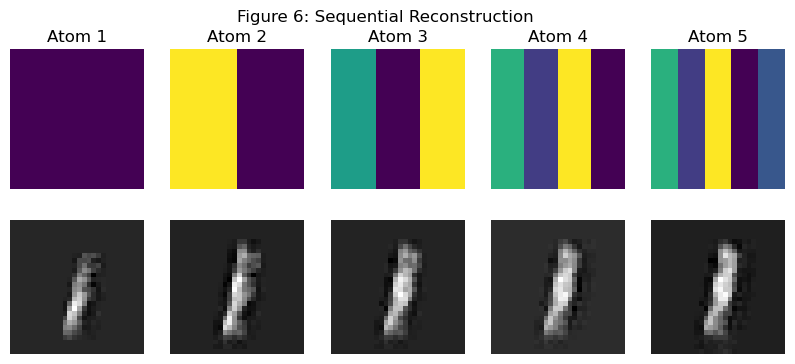

C:\Users\HP\AppData\Local\Temp\ipykernel_16020\1184425535.py:141: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embed[:, 0], embed[:, 1], cmap='Spectral')


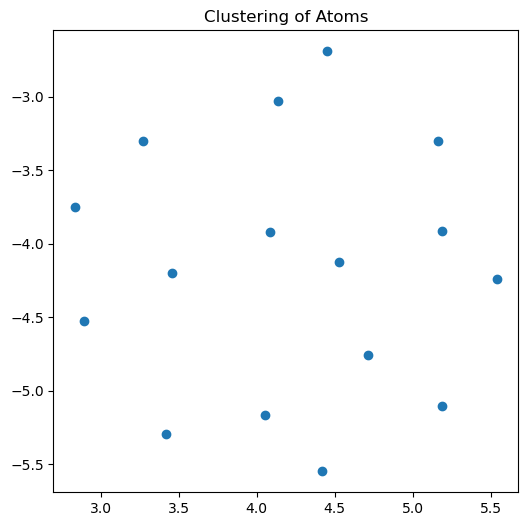

C:\Users\HP\AppData\Local\Temp\ipykernel_16020\1184425535.py:154: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embed[:, 0], embed[:, 1], cmap='Spectral')


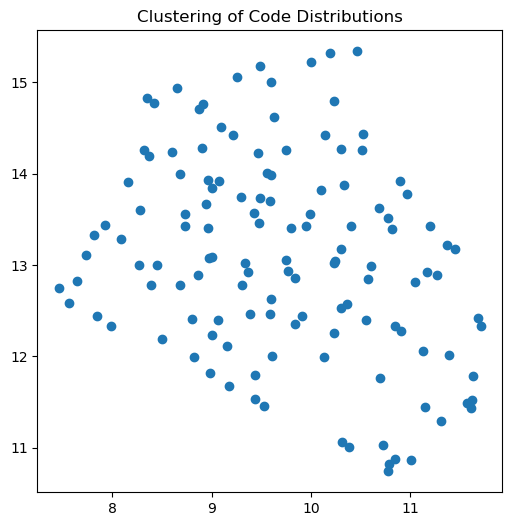

In [13]:
# ----------------------
# Load one MNIST batch
# ----------------------
def get_mnist_batch(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
    return next(iter(test_loader))

# ----------------------
# Run Postprocessing
# ----------------------
def run_postprocessing(model_path="trained_model.pth", top_k=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SparseAutoencoder(in_channels=1, num_kernels=16, kernel_size=7, k=10)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()

    x, _ = get_mnist_batch()
    x = x.to(device)

    with torch.no_grad():
        x_recon, pre_codes, codes, dictionary = model(x)
        z_sparse = codes  # `codes` already has Top-K sparsity applied
    
    print(codes.shape)

    # Visualizations and metrics
    # visualize_atoms(model.encoder.weight, title="Learned Atoms")
    visualize_conv_atoms(model.encoder.weight, title="Learned Conv Filters")

    l0_scores = sort_atoms_by_l0(z_sparse)
    visualize_sorted_atoms(model.encoder.weight, l0_scores, title="Atoms Sorted by L0")
    l1_scores = sort_atoms_by_l1(z_sparse)
    visualize_sorted_atoms(model.encoder.weight, l1_scores, title="Atoms Sorted by L1")
    print(l0_scores.shape, l1_scores.shape)

    visualize_codes_conv(z_sparse)

    global_babel = babel_score(model.encoder.weight)
    per_sample_babel = babel_score_for_sample(z_sparse, model.encoder.weight)
    print(f"Global Babel Score: {global_babel:.4f}")
    print(f"Per-Sample Babel Score (mean): {per_sample_babel:.4f}")

    sequential_reconstruction(x[0:1], z_sparse[0:1], model.decoder, top_k=top_k)
    cluster_atoms(model.encoder.weight.detach())
    cluster_codes(z_sparse)

if __name__ == "__main__":
    run_postprocessing("trained_model.pth", top_k=5)

In [11]:
cd saved_models/2025-06-23_13-54-03/

d:\fUSI\Code base\src\saved_models\2025-06-23_13-54-03


In [ ]:
# Postprocessing Script 


import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import KMeans
import seaborn as sns
from tqdm import tqdm

def flatten_if_needed(x):
    return x.view(x.shape[0], -1) if len(x.shape) > 2 else x

# 1. Visualize Atoms
def visualize_atoms(decoder_weight, num_atoms=25, title="Atoms"):
    atoms = decoder_weight[:num_atoms].cpu().detach().numpy()
    n_cols = min(num_atoms, 10)
    n_rows = int(np.ceil(num_atoms / n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows))
    axs = axs.flatten()
    for i in range(num_atoms):
        axs[i].imshow(atoms[i].reshape(28, 28), cmap='gray')
        axs[i].axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# 2. Sort & Visualize l0 Atoms
def sort_visualize_atoms_l0(codes, decoder_weight, top_n=25):
    freq = (codes != 0).sum(dim=0)
    top_idx = torch.topk(freq, top_n).indices
    visualize_atoms(decoder_weight[top_idx], top_n, title="Top-l0 Atoms")

# 3. Sort & Visualize l1 Atoms
def sort_visualize_atoms_l1(codes, decoder_weight, top_n=25):
    l1 = codes.abs().mean(dim=0)
    top_idx = torch.topk(l1, top_n).indices
    visualize_atoms(decoder_weight[top_idx], top_n, title="Top-l1 Atoms")

# 4. Visualize Codes
def visualize_codes_dense(codes, title="Code Heatmap"):
    sns.heatmap(codes.cpu().detach().numpy(), cmap='viridis', cbar=True)
    plt.title(title)
    plt.xlabel("Atoms")
    plt.ylabel("Samples")
    plt.show()

def visualize_codes_conv(codes, title="Code Distribution (Conv)"):
    batch_size, channels, H, W = codes.shape
    avg_map = codes.mean(dim=0).squeeze()
    plt.imshow(avg_map.cpu().numpy(), cmap='viridis')
    plt.title(title)
    plt.colorbar()
    plt.show()

# 5. Activation Value vs Frequency
def plot_activation_value_vs_frequency(codes):
    codes_np = codes.detach().cpu().numpy()
    freq = (codes_np != 0).sum(axis=0)
    avg_val = np.mean(np.abs(codes_np), axis=0)

    plt.scatter(freq, avg_val, alpha=0.6)
    plt.xlabel("Activation Frequency (l0)")
    plt.ylabel("Avg Activation Value (l1)")
    plt.title("Activation Value vs Frequency")
    plt.grid(True)
    plt.show()

# 6. Babel Score
def babel_score(dictionary, r=10):
    D = dictionary.detach().cpu().numpy()
    sim = np.abs(cosine_similarity(D, D))
    np.fill_diagonal(sim, 0)

    scores = []
    for j in range(D.shape[0]):
        scores.append(np.sum(np.sort(sim[j])[-r:]))
    return np.max(scores)

# 7. Babel Score of Selected Atoms
def babel_selected_atoms(codes, dictionary, r=10):
    selected_indices = (codes != 0).nonzero(as_tuple=False)[:, 1]
    selected_atoms = dictionary[selected_indices.unique()]
    return babel_score(selected_atoms, r=r)

# 8. Sequential Reconstruction
def sequential_reconstruction(x, code, decoder, top_k=10):
    recon = torch.zeros_like(x)
    residual = x.clone()
    indices = torch.topk(code.abs(), top_k).indices
    fig, axs = plt.subplots(2, top_k, figsize=(2 * top_k, 4))

    for i, idx in enumerate(indices):
        atom = decoder.weight[idx].view_as(x)
        contrib = code[idx] * atom
        recon += contrib
        residual -= contrib

        axs[0, i].imshow(atom.squeeze().cpu().numpy(), cmap='gray')
        axs[0, i].axis('off')
        axs[0, i].set_title(f"Atom {idx.item()}")

        axs[1, i].imshow(recon.squeeze().cpu().numpy(), cmap='gray')
        axs[1, i].axis('off')

    axs[0, 0].set_ylabel("Atom")
    axs[1, 0].set_ylabel("Recon")
    plt.tight_layout()
    plt.show()

# 9. Clustering

def cluster_umap(data, title="UMAP Cluster", n_clusters=10):
    reducer = umap.UMAP()
    embeddings = reducer.fit_transform(data.cpu().detach().numpy())
    kmeans = KMeans(n_clusters=n_clusters).fit(embeddings)
    labels = kmeans.labels_

    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], hue=labels, palette='tab10')
    plt.title(title)
    plt.legend()
    plt.show()